In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, sosfiltfilt, filtfilt, freqz
from scipy import signal
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d,gaussian_filter
import pickle
from skimage import io, filters
import glob
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
fly_num = 'fly_208'
func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/'
# load_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco.h5')
load_directory = os.path.join(func_path, 'func_0/moco/functional_channel_2_moco.h5')
# save_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco_highpass_test.h5')
# load_directory = os.path.join(func_path, 'func_0/functional_channel_2_moco_zscore.h5')
warp_directory = os.path.join(func_path,'warp')
load_dir = os.path.join(warp_directory,  'test.h5')

In [3]:
%%time
dff_dir = os.path.join(func_path, 'dff')
dff_path = os.path.join(dff_dir,  'test_dff.h5')
with h5py.File(dff_path, 'r') as hf:
        brain = hf['data'][:]
        ts = hf['timestamps'][:]
        dimsw = np.shape(brain)
        dimsts = np.shape(ts)
        print("Data shape is {} and timestamps shape is {}".format(dimsw, dimsts))

Data shape is (314, 146, 91, 162) and timestamps shape is (314, 146, 91, 162)
CPU times: user 0 ns, sys: 3.16 s, total: 3.16 s
Wall time: 13.8 s


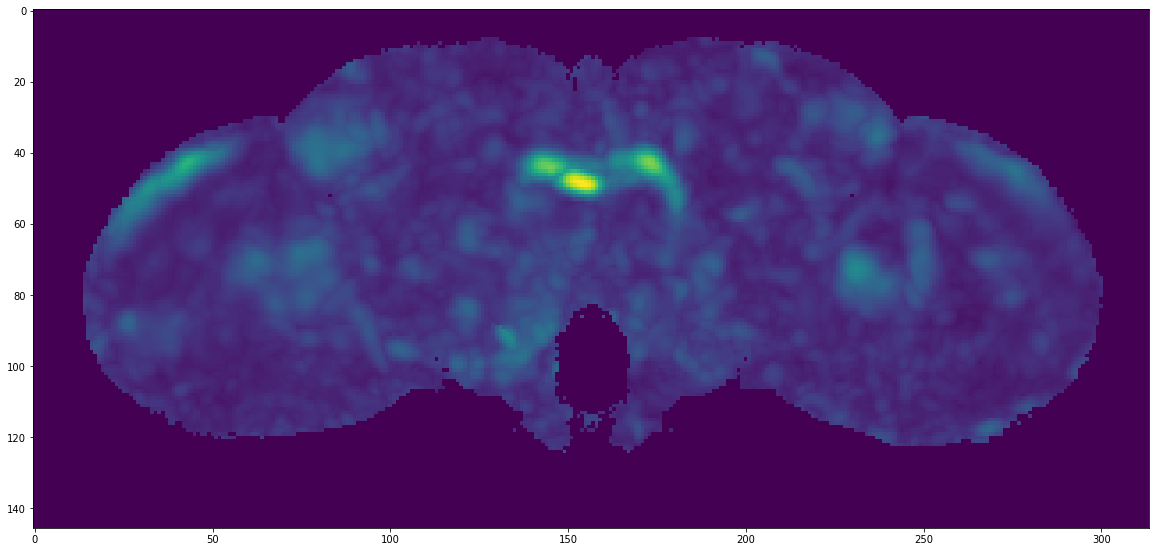

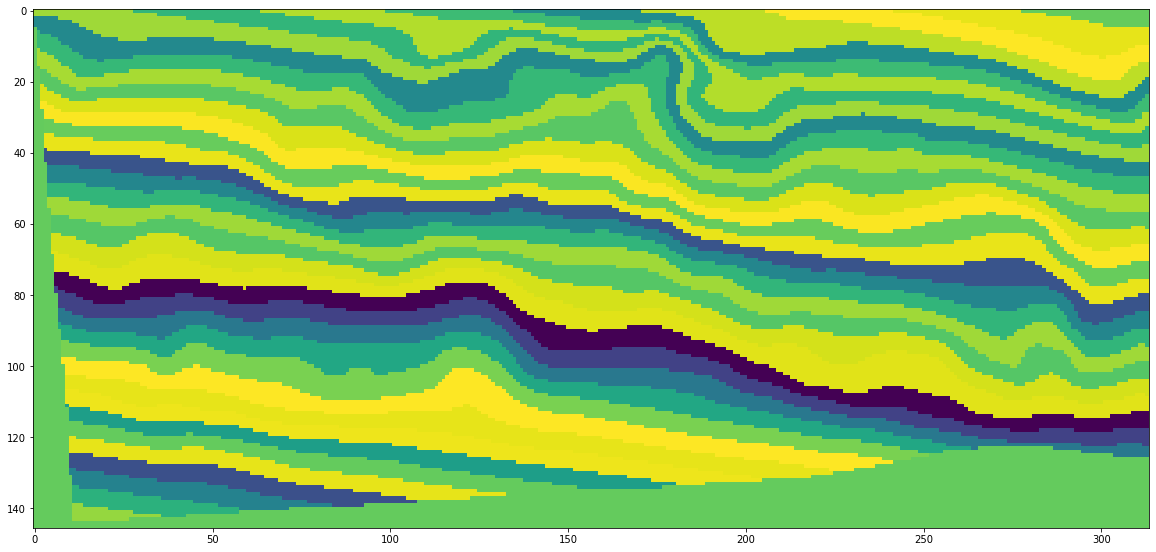

In [51]:
plt.figure(figsize=(20,20))
plt.imshow(np.nanmax(brain[:,:,20], axis=-1).T)
plt.figure(figsize=(20,20))
plt.imshow(np.nanmax(ts[:,:,20], axis=-1).T)
# plt.colorbar()

In [54]:

#initialize a big data matrix for the output
# data_interp = [vox1, vox2, vox3, interp# of time points (here 100)]

#repeat for every voxel
# data_interp[i,j,k] = .. the interpolated thing we make below


t=ts[100,50,20] #times
y=brain[100,50,20] #signal

t_interp = np.linspace(-500, 2000, 100) #these are the times in ms that we will resample everything to

f_interp = scipy.interpolate.interp1d(t,y) #can look at the docstring for interp1d
y_interp = f_interp(t_interp) # these will be y values interpolated to the new standardized times



ValueError: A value in x_new is below the interpolation range.

In [5]:
bin_0=np.where(ts<=0)
# bin_0=bin_0[0,...]

In [6]:
before_stim = np.zeros_like(brain)
before_stim[bin_0] = brain[bin_0]

In [7]:
np.shape(before_stim)

(314, 146, 91, 162)

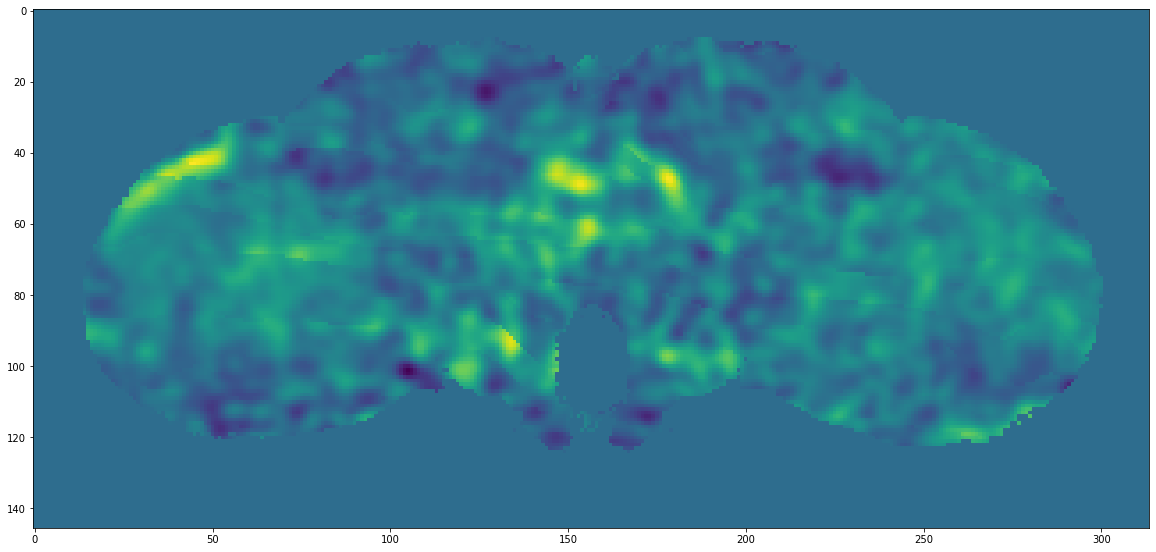

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(np.nanmean(before_stim[:,:,20], axis=-1).T)

In [9]:
bin_start = -500; bin_end = 2000; bin_size = 100 #ms
neural_bins = np.arange(bin_start,bin_end,bin_size)

In [10]:
# shape=np.shape(brain)[:-1]
binned_brain = np.zeros(np.shape(brain)[:-1])
np.shape(binned_brain)

(314, 146, 91)

In [11]:
%%time
time_binned_brain=[]
for edge in neural_bins:
    if edge != bin_start:
        start_edge=edge-bin_size
        end_edge=edge
        time_bin = np.where((ts>=start_edge) & (ts<end_edge))
        binned_brain = np.zeros_like(brain)
        binned_brain[time_bin] = brain[time_bin]
#         print(np.shape(binned_brain))
        binned_brain=np.nanmean(binned_brain, axis=-1)
#         print(np.shape(binned_brain))
        time_binned_brain.append(binned_brain)

CPU times: user 1min 27s, sys: 45 s, total: 2min 12s
Wall time: 2min 12s


In [12]:
time_binned_brain = np.asarray(time_binned_brain)

In [13]:
dims=np.shape(time_binned_brain)
dims

(24, 314, 146, 91)

In [48]:
print("Max:{} Min:{}".format(np.max(time_binned_brain), np.min(time_binned_brain)))

Max:0.03110460937023163 Min:-0.009648952633142471


/home/users/ilanazs/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



ValueError: operands could not be broadcast together with shapes (25,) (314,146,91) 

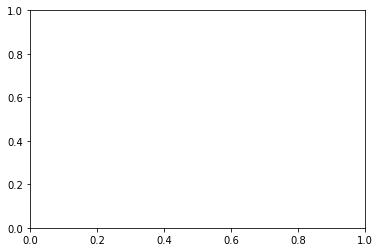

In [49]:
plt.hist2d(neural_bins, time_binned_brain[10,...])

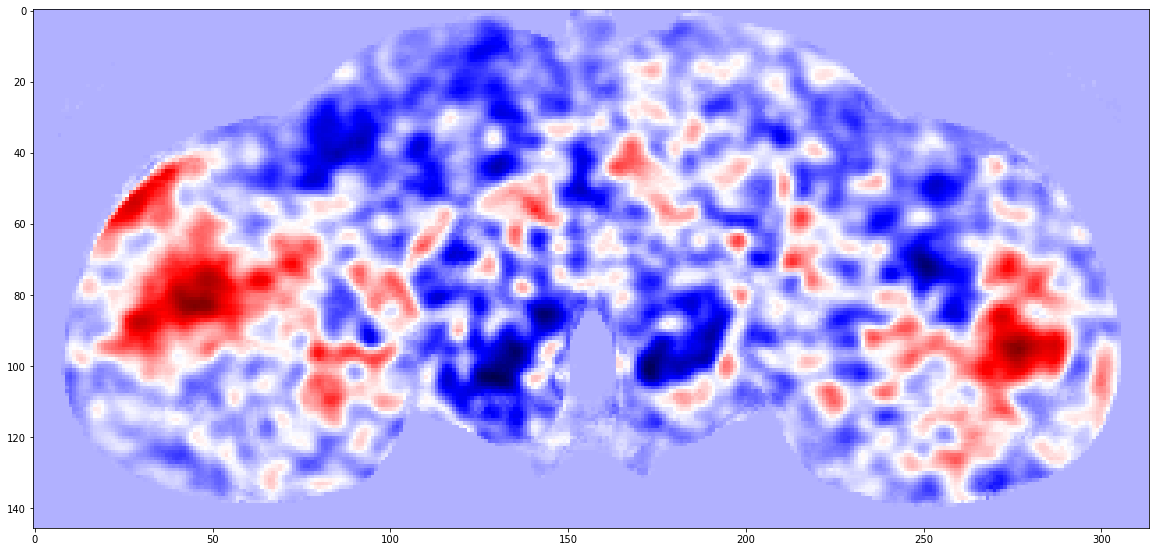

In [45]:
plt.figure(figsize=(20,20))
plt.imshow(np.nanmean(time_binned_brain[23,...], axis=-1).T, cmap='seismic')

In [47]:
# plt.figure(figsize=(10,10))
# for i in range(24):
#     print(i)
#     plt.imshow(np.nanmean(time_binned_brain[i,...], axis=-1).T, cmap='seismic') 
#     plt.axis('off')
#     fname = os.path.join(save_dir, '{0:05d}.png'.format(i))
#     plt.savefig(fname,dpi=300,bbox_inches='tight')

In [42]:
def extract_roi_signal_traces(roi_ids, roi_masks, warps, hemi, signal_type):
    t0 = time.time()
    roi_time_avgs = []
    for roi in roi_ids[hemi]:
        mask = roi_masks[roi]
        masked_data = warps[:,:,:,:]*mask[np.newaxis,:,:,:] #note z-flip
        if signal_type == 'max':
            roi_time_avg = np.max(masked_data,axis=(1,2,3))
        elif signal_type == 'mean':
            roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    print(time.time()-t0)
    return np.asarray(roi_time_avgs)

In [44]:
atlas = brainsss.load_roi_atlas()

In [45]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [47]:
%%time
explosions = []
for tp in range(24):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = time_binned_brain[tp][:,:,::-1]
    vmax = 0.5 #this was 0.5 for STA <------------
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic', diverging=True)#'hot')
    explosions.append(explosion_map)

CPU times: user 25.4 s, sys: 705 ms, total: 26.1 s
Wall time: 26.2 s


In [49]:
os.listdir(os.path.join(func_path, 'movies'))

['test_dff',
 'total_channel2',
 'test.nii',
 'total',
 'flat',
 'increase',
 'decrease']

In [42]:
movie_dir = os.path.join(func_path, 'movies')
if os.path.exists(movie_dir)==False:
    os.mkdir(movie_dir)
print(movie_dir)

/oak/stanford/groups/trc/data/Ilana/2P/data/fly_208/movies


In [43]:
save_dir = os.path.join(movie_dir,'test_dff')
if os.path.exists(save_dir)==False:
    os.mkdir(save_dir)
print(save_dir)

/oak/stanford/groups/trc/data/Ilana/2P/data/fly_208/movies/test_dff


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


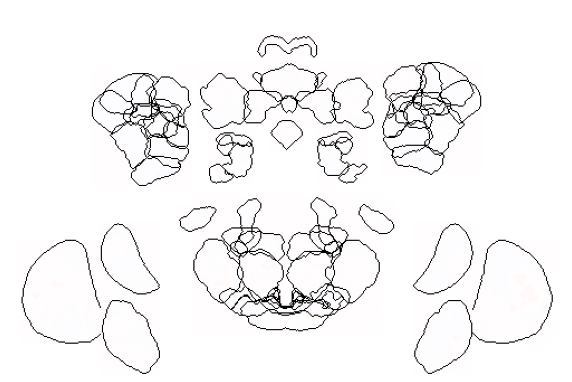

In [52]:
plt.figure(figsize=(10,10))
for i in range(24):
    print(i)
    plt.imshow(explosions[i][170:,:]) #this was made with cmap=hot
    plt.axis('off')
    fname = os.path.join(save_dir, '{0:05d}.png'.format(i))
    plt.savefig(fname,dpi=300,bbox_inches='tight')